# Проект: классификация

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
plt.style.use('seaborn-v0_8-whitegrid')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [253]:
# from google.colab import files
# files.upload();

In [254]:
df = pd.read_csv('/content/bank_fin.csv', sep = ';')
df[:3]

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [256]:
# найдем пропуски в данных
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [257]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [258]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

In [259]:
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace('$', '').astype('float')
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [260]:
df['balance'].mean().round(3)

1529.129

### Задание 4

In [261]:
# заменяем пропуски медианным значеним по признаку balance
df['balance'].fillna(df['balance'].median(), inplace=True)
df['balance'].isna().sum()

0

In [262]:
df['balance'].mean().round(3)

1526.936

### Задание 5

In [263]:
# для категориальных прзнаков job и education заменяем пропущенные значения модальным значением по признаку
df['job'] = df['job'].apply(lambda x : df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x : df['education'].mode()[0] if x == 'unknown' else x)

In [264]:
df['job'].value_counts()[:1], df['education'].value_counts()[:1]

(job
 management    2636
 Name: count, dtype: int64,
 education
 secondary    5973
 Name: count, dtype: int64)

In [265]:
# средний баланс у клиентов с наиболее популярной профессией и уровнем образования
df[(df['job']=='management') & (df['education'] == 'secondary')]['balance'].mean().round(3)

1598.883

### Задание 6

In [266]:
# функция для определения индексов записей, являющихся выбросами
def get_outliers_ind(col, df):
    first_quantile = np.quantile(df[col], q=0.25)
    third_quantile = np.quantile(df[col], q=0.75)
    iqr = third_quantile - first_quantile
    low_border = first_quantile - 1.5*iqr
    high_border = third_quantile + 1.5*iqr
    outliers_ind = df[col][(df[col] < low_border) | (df[col] > high_border)].index
    print('Нижняя граница поиска выбросов по методу Тьюки: {}'.format(low_border))
    print('Верхняя граница поиска выбросов по методу Тьюки: {}'.format(high_border))
    print('Количество значений, находящихся за пределами интрвала: {}'.format(len(outliers_ind)))
    return outliers_ind


Text(0.5, 1.0, 'Распределение признака balance')

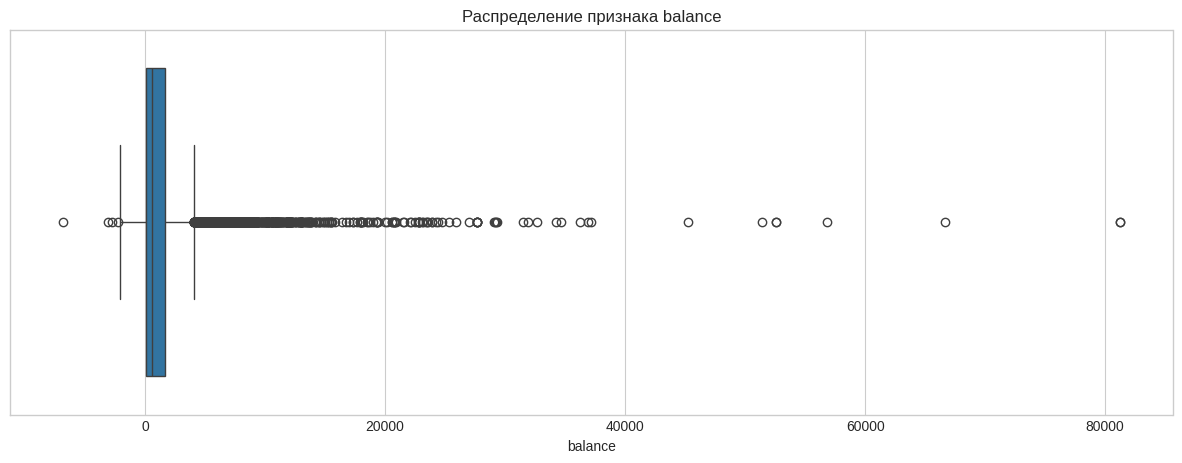

In [267]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df['balance'], orient='h',)
ax.set_title('Распределение признака balance')

In [268]:
ind = get_outliers_ind('balance', df)

Нижняя граница поиска выбросов по методу Тьюки: -2241.0
Верхняя граница поиска выбросов по методу Тьюки: 4063.0
Количество значений, находящихся за пределами интрвала: 1057


In [269]:
# удалим выбросы в признаке balance
df = df[~df.index.isin(ind)]
print(f'Количество объектов после удаления выбросов: {len(df)}')

Количество объектов после удаления выбросов: 10105


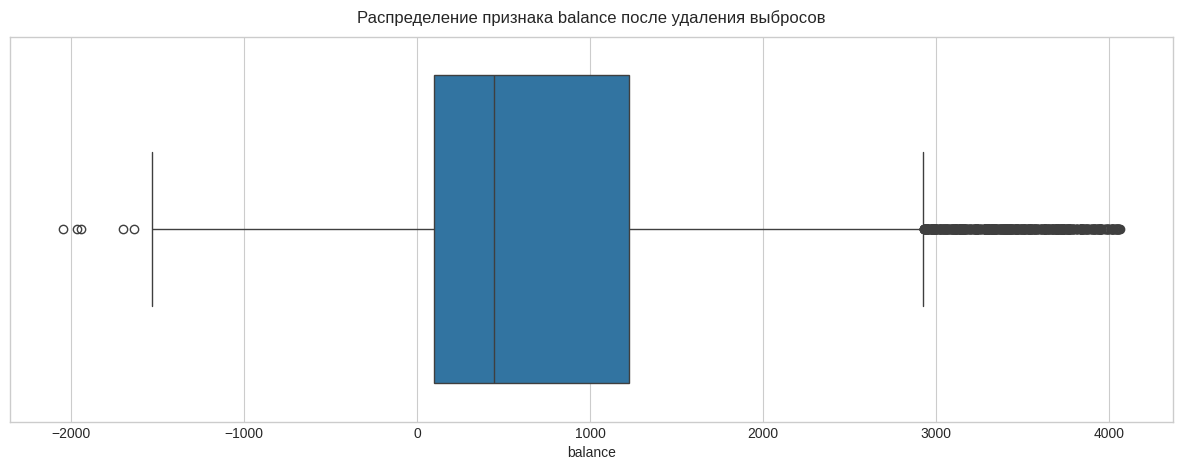

In [270]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(df['balance'], orient='h')
ax.set_title('Распределение признака balance после удаления выбросов', pad = 10);

## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

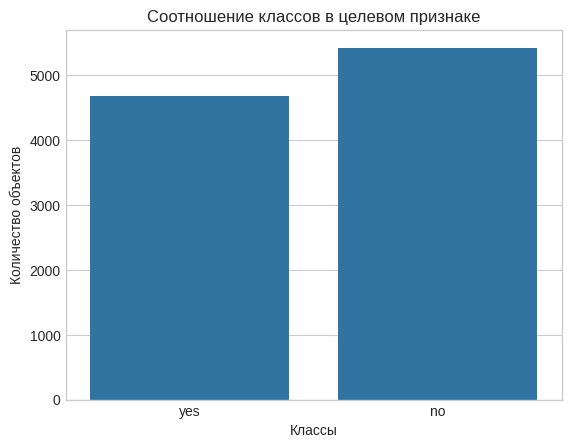

In [271]:
# определеим баланс классов целевого признака
display(df['deposit'].value_counts())
print()
sns.countplot(data = df, x='deposit')
plt.title('Соотношение классов в целевом признаке')
plt.xlabel('Классы')
plt.ylabel('Количество объектов');

Присутствует незначительный дисбаланс в соотношении классов (47% vs 52%), которым можно пренебречь

### Задания 2 и 3

In [272]:
# расчитаем описательные статистики для числовых признаков
df.describe()

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

Сравнивая минимальные и максимальные значения признаков можно сказать, что масштаб признаков сильно отличается и для построения модели признакам необходима стандартизация или нормализация. Медианное значение признака 'age' немного меньше среднего значения, что говорит о небольшом перекосе распределения в область меньших значений, однако разница невелика и распределение признака близко к нормальному. Распределение признака balance также скошено вправо, медианное значение находится относительно близко к нулю, из чего можно сделать вывод, что половина всех клиентов держат на счете не слишком большие суммы.

In [273]:
# список с названиями числовых признаков
num_features = df.select_dtypes(include=['number']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

Text(0.5, 0.98, 'Распределение данных')

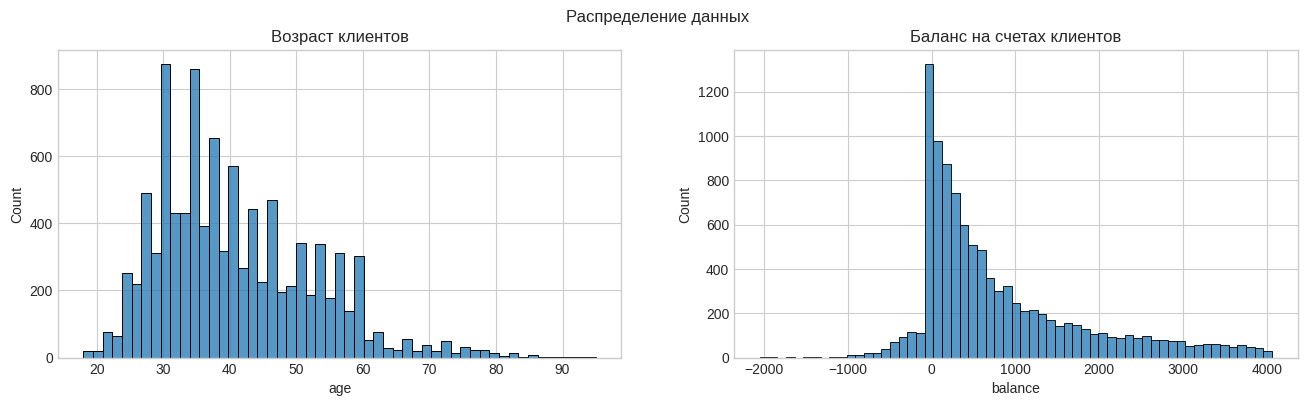

In [274]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
sns.histplot(data=df, x='age', ax=ax[0]);
ax[0].set_title('Возраст клиентов');
sns.histplot(data=df, x='balance', ax=ax[1]);
ax[1].set_title('Баланс на счетах клиентов');
plt.suptitle('Распределение данных')

Text(0.5, 0.98, 'Распределение данных')

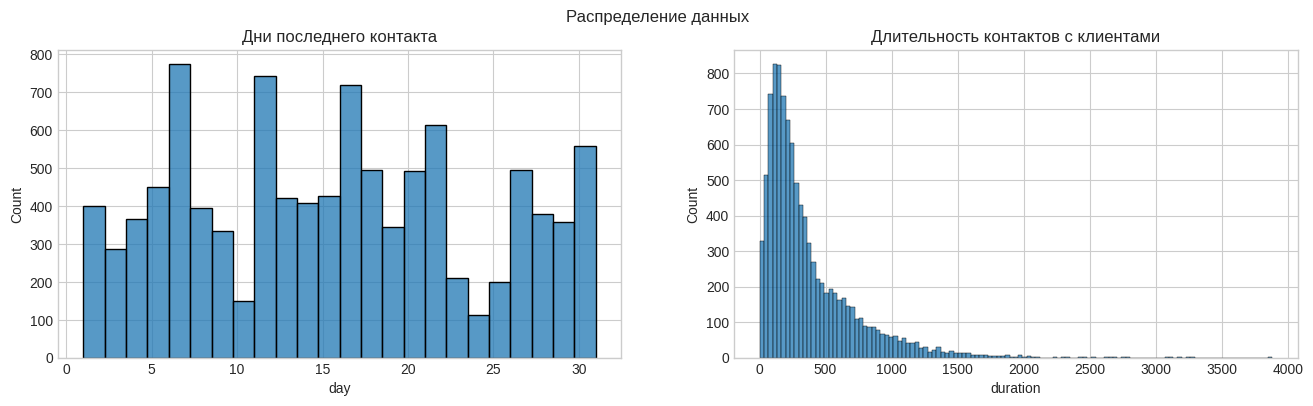

In [275]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
sns.histplot(data=df, x='day', ax=ax[0]);
ax[0].set_title('Дни последнего контакта');
sns.histplot(data=df, x='duration', ax=ax[1]);
ax[1].set_title('Длительность контактов с клиентами');
plt.suptitle('Распределение данных')

Распределение дней относительно равномерное с всплесками активности каждые 5 дней, возможно, связанные с концом рабочей недели и необходимостью большей интенсивности для достижения плановых показателей.
Распределение времени контактов с клиентами сильно скошено вправо, что говорит о том, что длительность большинства контактов не превышает 5 минут (медианное значение - 252), вметсе с тем максимальное значение по признаку duration составляет 3881 с (56 мин), и также есть значения более 1500 с, которые могут быть выбросами

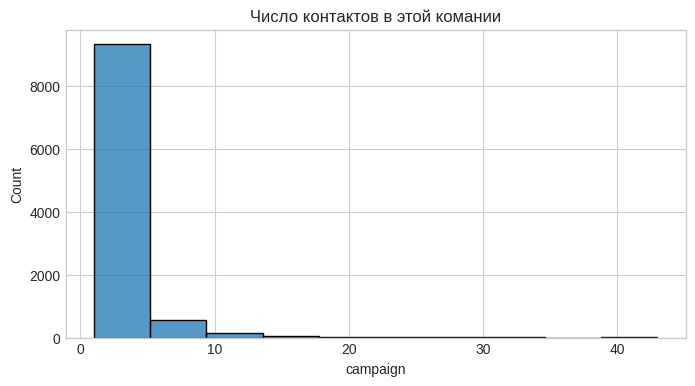

In [276]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=df, x='campaign', bins=10);
ax.set_title('Число контактов в этой комании');

Число контактов в этой маркетинговой компании в основном не больше 5 (медианной значение составляет 2). Значения больше 15-20 контактов, по всей видимости, являются аномальными

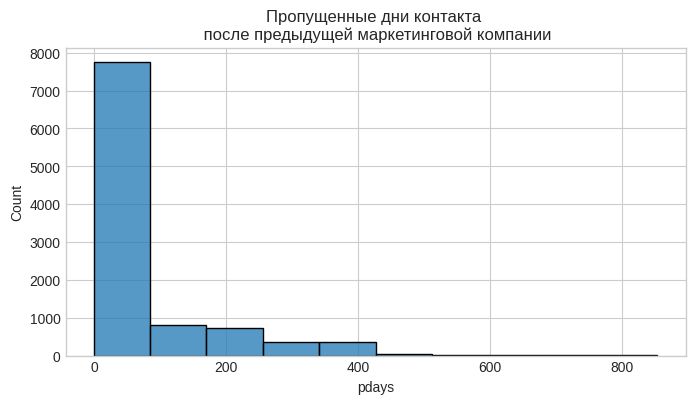

In [277]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=df, x='pdays', bins=10);
ax.set_title('Пропущенные дни контакта \n после предыдущей маркетинговой компании');

Большинство значений проущенных дней состредоточены вблизи нуля (медианное значение -1), что может значить, что контакты разрыв в контактах с клиентами между разными компаниями сведен к минимуму, и, возможно, контакты в рамках текущей компании начались еще во время окончания предыдущей. 75 % перерыва в контактах не превышало 2 дня (3 квартиль)

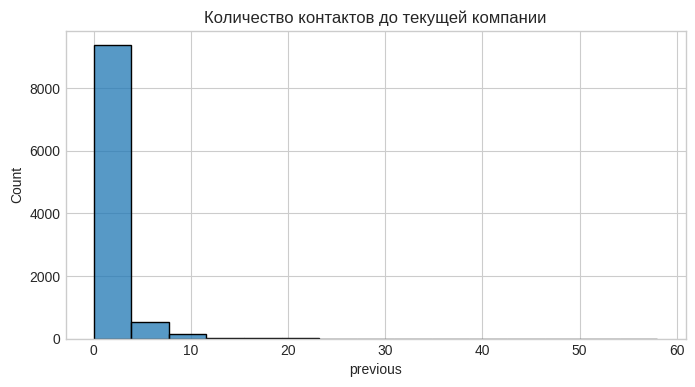

In [278]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=df, x='previous', bins=15);
ax.set_title('Количество контактов до текущей компании');

В текущей компании достаточно мало контактов с клиентами (медианное значение 0, 3 квартиль соответствует значению 1). Возможно, маркетинговая компания только началась.

### Задания 4 и 5

In [279]:
# выведем описательные статистики для категориальных признаков
df[cat_features].describe(include='object')

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424

Среди клиентов банка представлено 11  сфер занятости, и наибольшее количество клиентов (2315) работают в сфере management. БОльшая часть всех клентов (5715) состоят в браке. БОльшая часть клиентов (5517) имеет среднее образование (secondary). Большинство клиентов не имеют кредитов. Результаты прошлой кампании для большинства клиентов (7570 из 10105) неизвестны. Этот признак в виду его неинформативности можно удалить. C большей частью клиентов был контакт по мобильному телефону.

Text(0.5, 0.98, 'Связь кредитных обязательств с видом занятости')

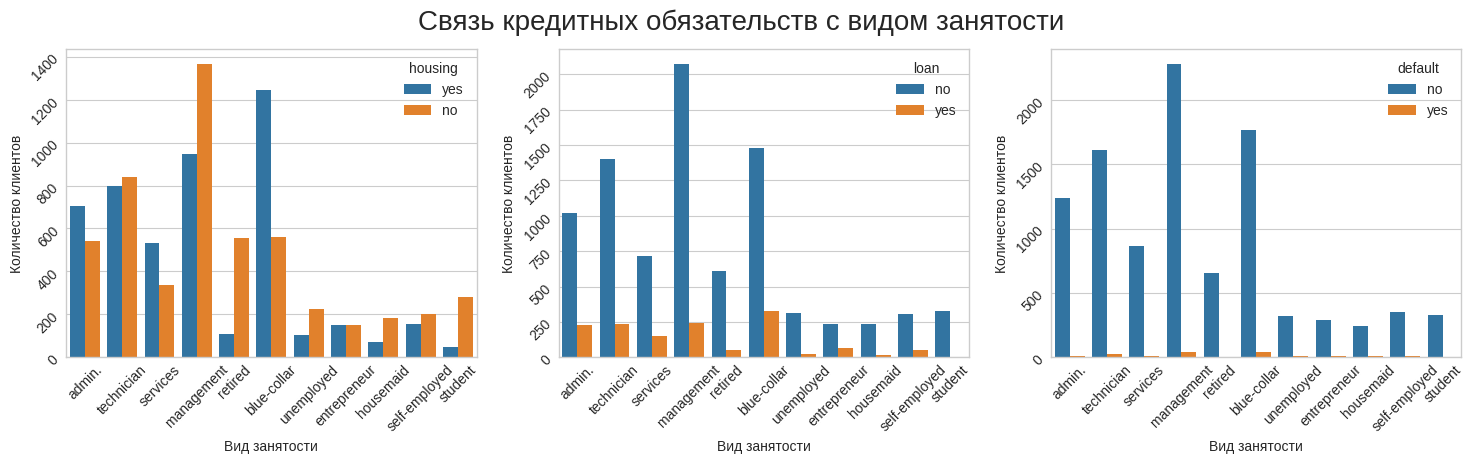

In [280]:
# визуализируем информацию из категориальных признаки
fig = plt.figure(figsize=(18, 4))

ax1 = plt.subplot(131)
ax1.tick_params(rotation=45)
sns.countplot(df, x='job', hue='housing')
plt.xlabel('Вид занятости')
plt.ylabel('Количество клиентов')

ax2 = plt.subplot(132)
ax2.tick_params(rotation=45)
sns.countplot(df, x='job', hue='loan')
plt.xlabel('Вид занятости')
plt.ylabel('Количество клиентов')

ax3 = plt.subplot(133)
ax3.tick_params(rotation=45)
sns.countplot(df, x='job', hue='default')
plt.xlabel('Вид занятости')
plt.ylabel('Количество клиентов')

plt.suptitle('Связь кредитных обязательств с видом занятости', fontsize=20)

По диаграмме можно сделать вывод, что больше 2/3 рабочих (blue_collar) имеют кредит на жилье.В то же время большая половины клиентов-менеджеров не имеют кредита на жилье. В остальных группах наличие и отсутствие кредита на жилье распределено примерно пополам, за исключением пенсионеров и студентов, что вполне объяснимо. В отношении других кредитов (loan и default) не прослеживается какой-либо связи с видом занятости.

Text(0.5, 0.98, 'Связь кредитных обязательств с семейным положением')

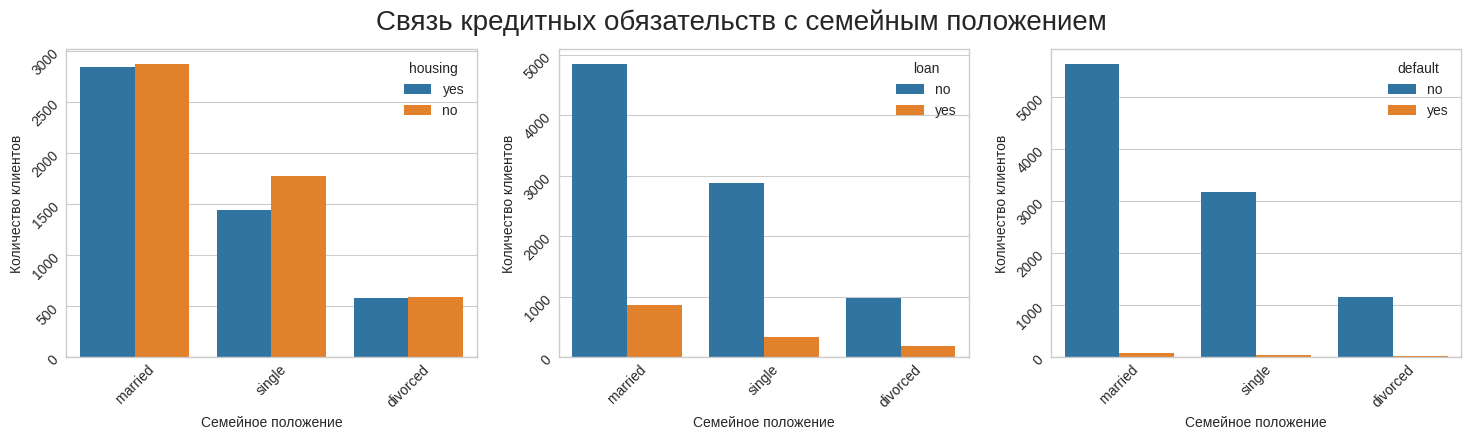

In [281]:
# визуализируем информацию из категориальных признаки
fig = plt.figure(figsize=(18, 4))

ax1 = plt.subplot(131)
ax1.tick_params(rotation=45)
sns.countplot(df, x='marital', hue='housing')
plt.xlabel('Семейное положение')
plt.ylabel('Количество клиентов')

ax2 = plt.subplot(132)
ax2.tick_params(rotation=45)
sns.countplot(df, x='marital', hue='loan')
plt.xlabel('Семейное положение')
plt.ylabel('Количество клиентов')

ax3 = plt.subplot(133)
ax3.tick_params(rotation=45)
sns.countplot(df, x='marital', hue='default')
plt.xlabel('Семейное положение')
plt.ylabel('Количество клиентов')

plt.suptitle('Связь кредитных обязательств с семейным положением', fontsize=20)

Судя по диаграммам нет особой связи между семейным положением и наличием кредитных обязательств, во всех трёх группах примерно поровну людей, имеющих кредит на жилье, кроме небольшого перевеса в сторону отсутствия кредита в группе клиентов не состоящих в браке настоящее время и не находящихся в разводе (single). Относительно других признаков, связанных с кредитами ситуация не меняется от группы к группе, что говорит об отсутствии связи этих признаков с семейным положением.

Text(0.5, 0.98, 'Связь кредитных обязательств с уровнем образования')

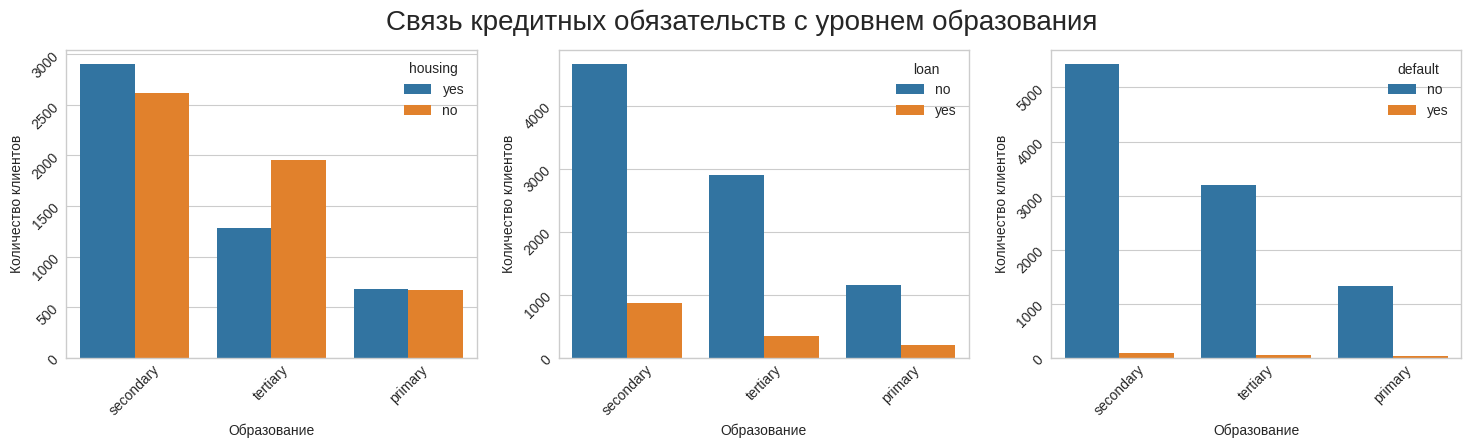

In [282]:
# визуализируем информацию из категориальных признаки
fig = plt.figure(figsize=(18, 4))

ax1 = plt.subplot(131)
ax1.tick_params(rotation=45)
sns.countplot(df, x='education', hue='housing')
plt.xlabel('Образование')
plt.ylabel('Количество клиентов')

ax2 = plt.subplot(132)
ax2.tick_params(rotation=45)
sns.countplot(df, x='education', hue='loan')
plt.xlabel('Образование')
plt.ylabel('Количество клиентов')

ax3 = plt.subplot(133)
ax3.tick_params(rotation=45)
sns.countplot(df, x='education', hue='default')
plt.xlabel('Образование')
plt.ylabel('Количество клиентов')

plt.suptitle('Связь кредитных обязательств с уровнем образования', fontsize=20)

По диаграммам можно сделать вывод, что ипотека больше свойственна клиентам со средним образованием, хотя эту разницу еще необходимо статистически обосновать. Среди клиентов с высшим (tertiary) образованием большая часть не имеет кредита на жилье, что по всей видимости связано с бОльшим уровнем доходов. По остальным кредитным признакам зависимости с уровнем образования не прослеживается.

### Задание 6

In [283]:
# посмотрим как влияют успехи предыдущей компании на результаты в текущей компании
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64

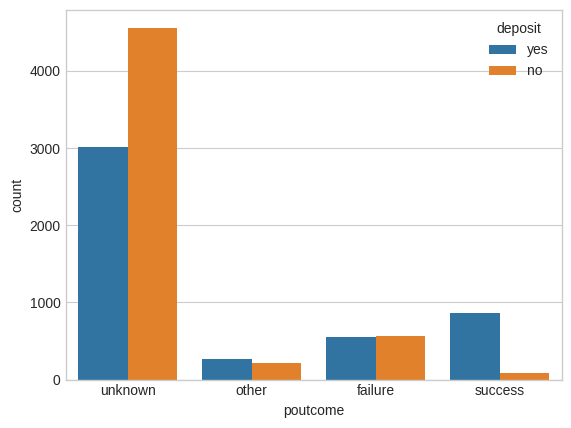

In [284]:
sns.countplot(df, x='poutcome', hue='deposit');

### Задание 7

In [285]:
months = df.groupby('month')['deposit'].value_counts(normalize=True).round(2) * 100
months.unstack()['no']

month
apr    38.0
aug    56.0
dec    10.0
feb    46.0
jan    61.0
jul    59.0
jun    55.0
mar    10.0
may    68.0
nov    58.0
oct    19.0
sep    17.0
Name: no, dtype: float64

Наибольшее количество неудач приходится на май

### Задание 8

In [286]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def range_by_age(x):
    if x < 30:
        x = '<30'
    elif 30 <= x < 40:
        x = '30-40'
    elif 40 <= x < 50:
        x = '40-50'
    elif 50 <= x < 60:
        x = '50-60'
    else:
        x = '60+'
    return x


df['age_grouped'] = df['age'].apply(range_by_age)
# age_grouped = df['age_grouped'].value_counts(normalize = True).round(2) * 100

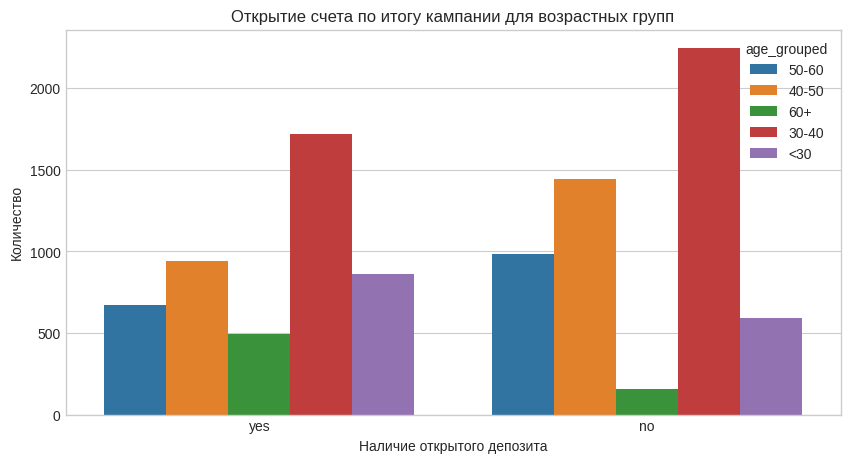

In [287]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='deposit', hue='age_grouped')
plt.xlabel('Наличие открытого депозита')
plt.ylabel('Количество')
plt.title('Открытие счета по итогу кампании для возрастных групп');

Судя по диаграмме можно сказать, что положительный эффект кампании прослеживается в возрастных группах '60+' и '<30', для остальных групп эффект отрицательный. В то же время для всех групп нельзя исключать и отстутвия эффекта кампании, т.к. гипотезы о положительном и отрицательном требуют статистической проверки.

### Задания 9 и 10

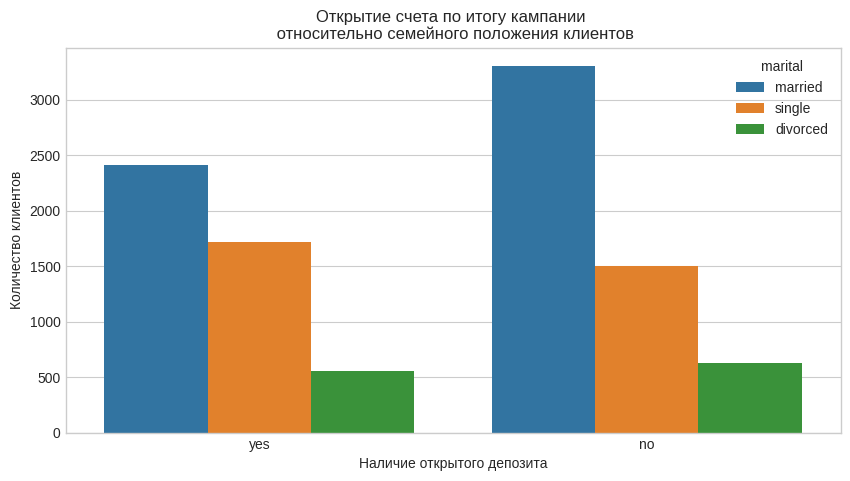

In [288]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='deposit', hue='marital')
plt.xlabel('Наличие открытого депозита')
plt.ylabel('Количество клиентов')
plt.title('Открытие счета по итогу кампании \n относительно семейного положения клиентов');

По итогам кампании большее количество неоткрытых счетов приходится на клиентов, состоящих в браке. В остальных группах эффект кампании не заметен.   

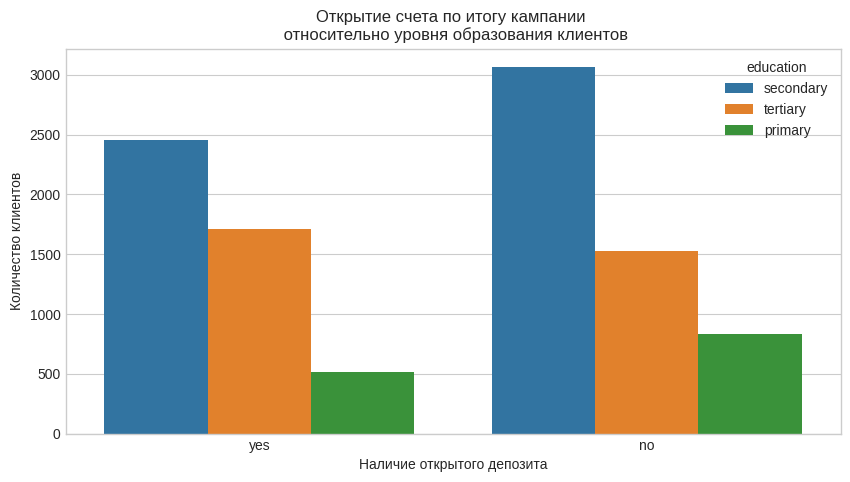

In [289]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='deposit', hue='education')
plt.xlabel('Наличие открытого депозита')
plt.ylabel('Количество клиентов')
plt.title('Открытие счета по итогу кампании \n относительно уровня образования клиентов');

В группах клиентов со средним и начальным (общим) образованием количество клиентов не открывших депозит несколько больше по сравнению с количеством открывших.

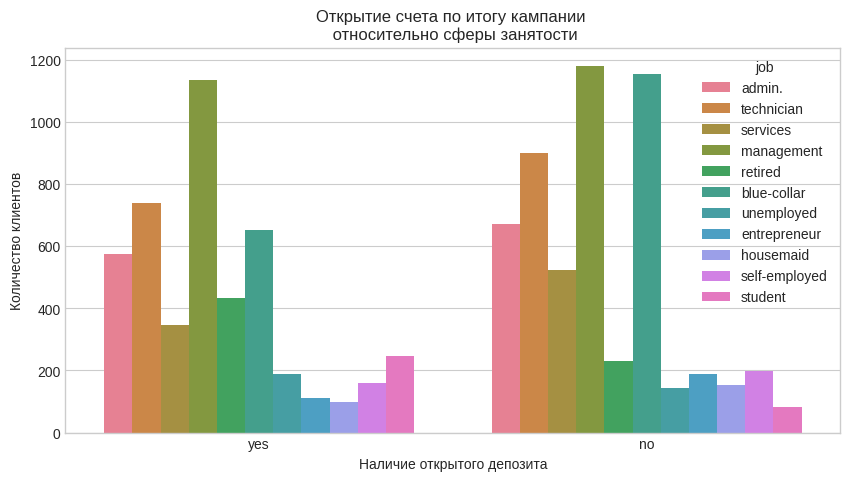

In [290]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='deposit', hue='job')
plt.xlabel('Наличие открытого депозита')
plt.ylabel('Количество клиентов')
plt.title('Открытие счета по итогу кампании \n относительно сферы занятости');

Больше всего клиентов, открывших счет среди пенсионеров и студентов, среди групп, в которых большинство клиентов не открыли депозит - рабочие.

### Задание 11

In [291]:
positive = df[df['deposit']=='yes']
negative = df[df['deposit']=='no']

Text(0.5, 1.0, 'Количество клиентов, не открывших депозит, \nв зависимости от уровня образования \nи семейного положения')

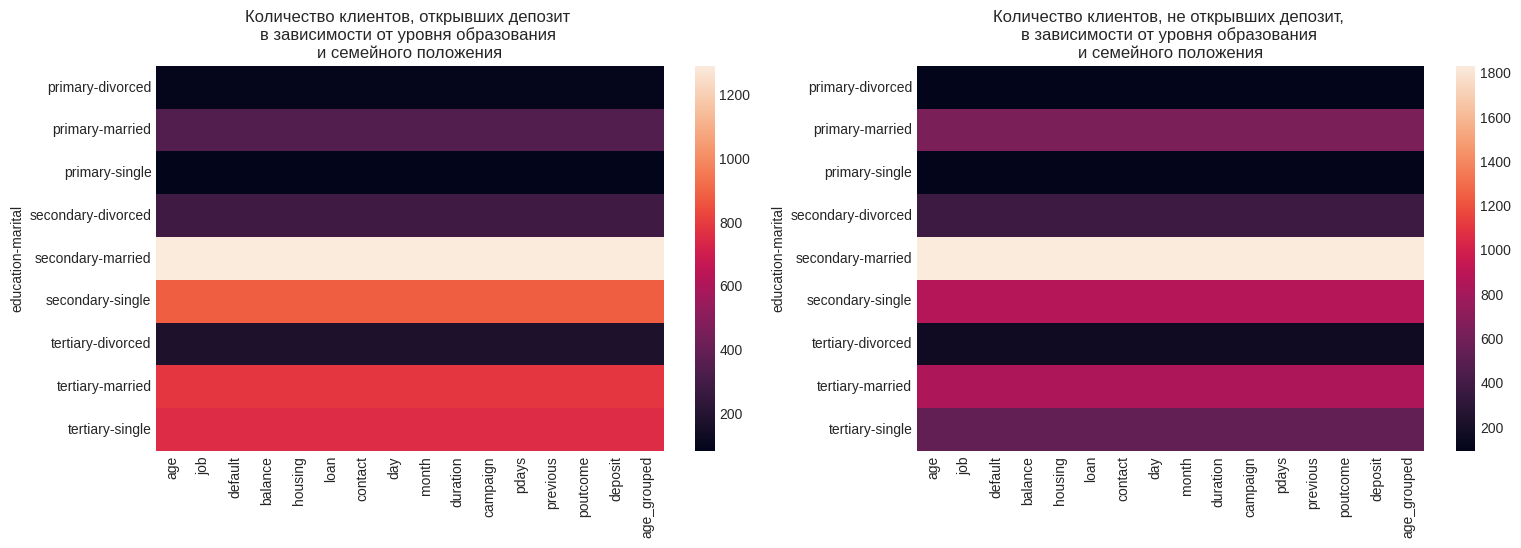

In [292]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(positive.groupby(['education', 'marital']).count(), ax=ax[0])
ax[0].set_title('Количество клиентов, открывших депозит \nв зависимости от уровня образования \nи семейного положения')

sns.heatmap(negative.groupby(['education', 'marital']).count(), ax=ax[1])
ax[1].set_title('Количество клиентов, не открывших депозит, \nв зависимости от уровня образования \nи семейного положения')

## Часть 3: преобразование данных

### Задание 1

In [293]:
df

age          job  marital  education default  balance housing loan  \
0       59       admin.  married  secondary      no   2343.0     yes   no   
1       56       admin.  married  secondary      no     45.0      no   no   
2       41   technician  married  secondary      no   1270.0     yes   no   
3       55     services  married  secondary      no   2476.0     yes   no   
4       54       admin.  married   tertiary      no    184.0      no   no   
...    ...          ...      ...        ...     ...      ...     ...  ...   
11157   33  blue-collar   single    primary      no      1.0     yes   no   
11158   39     services  married  secondary      no    733.0      no   no   
11159   32   technician   single  secondary      no     29.0      no   no   
11160   43   technician  married  secondary      no      0.0      no  yes   
11161   34   technician  married  secondary      no      0.0      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
3       unknown    5   may       579         1     -1         0  unknown   
4       unknown    5   may       673         2     -1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11157  cellular   20   apr       257         1     -1         0  unknown   
11158   unknown   16   jun        83         4     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

      deposit age_grouped  
0         yes       50-60  
1         yes       50-60  
2         yes       40-50  
3         yes       50-60  
4         yes       50-60  
...       ...         ...  
11157      no       30-40  
11158      no       30-40  
11159      no       30-40  
11160      no       40-50  
11161      no       30-40  

[10105 rows x 18 columns]

In [294]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['education'] = encoder.fit_transform(df['education'])
df['education'].sum()
df['age_grouped'] = encoder.fit_transform(df['age_grouped'])
df['deposit'] = df['deposit'].apply(lambda x : 0 if x=='no' else 1)

In [295]:
df.deposit.std().round(3)

0.499

### Задания 2 и 3

In [296]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['default'] = df['default'].replace({'yes':1, 'no':0})
df['housing'] = df['housing'].replace({'yes':1, 'no':0})
df['loan'] = df['loan'].replace({'yes':1, 'no':0})

In [297]:
print((df['default'].mean() + df['housing'].mean() + df['loan'].mean()).round(3))

0.635


### Задание 4

In [298]:
df = pd.get_dummies(data = df, columns = ['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False, dtype='int')
len(df.columns)

46

### Задания 5 и 6

<Axes: >

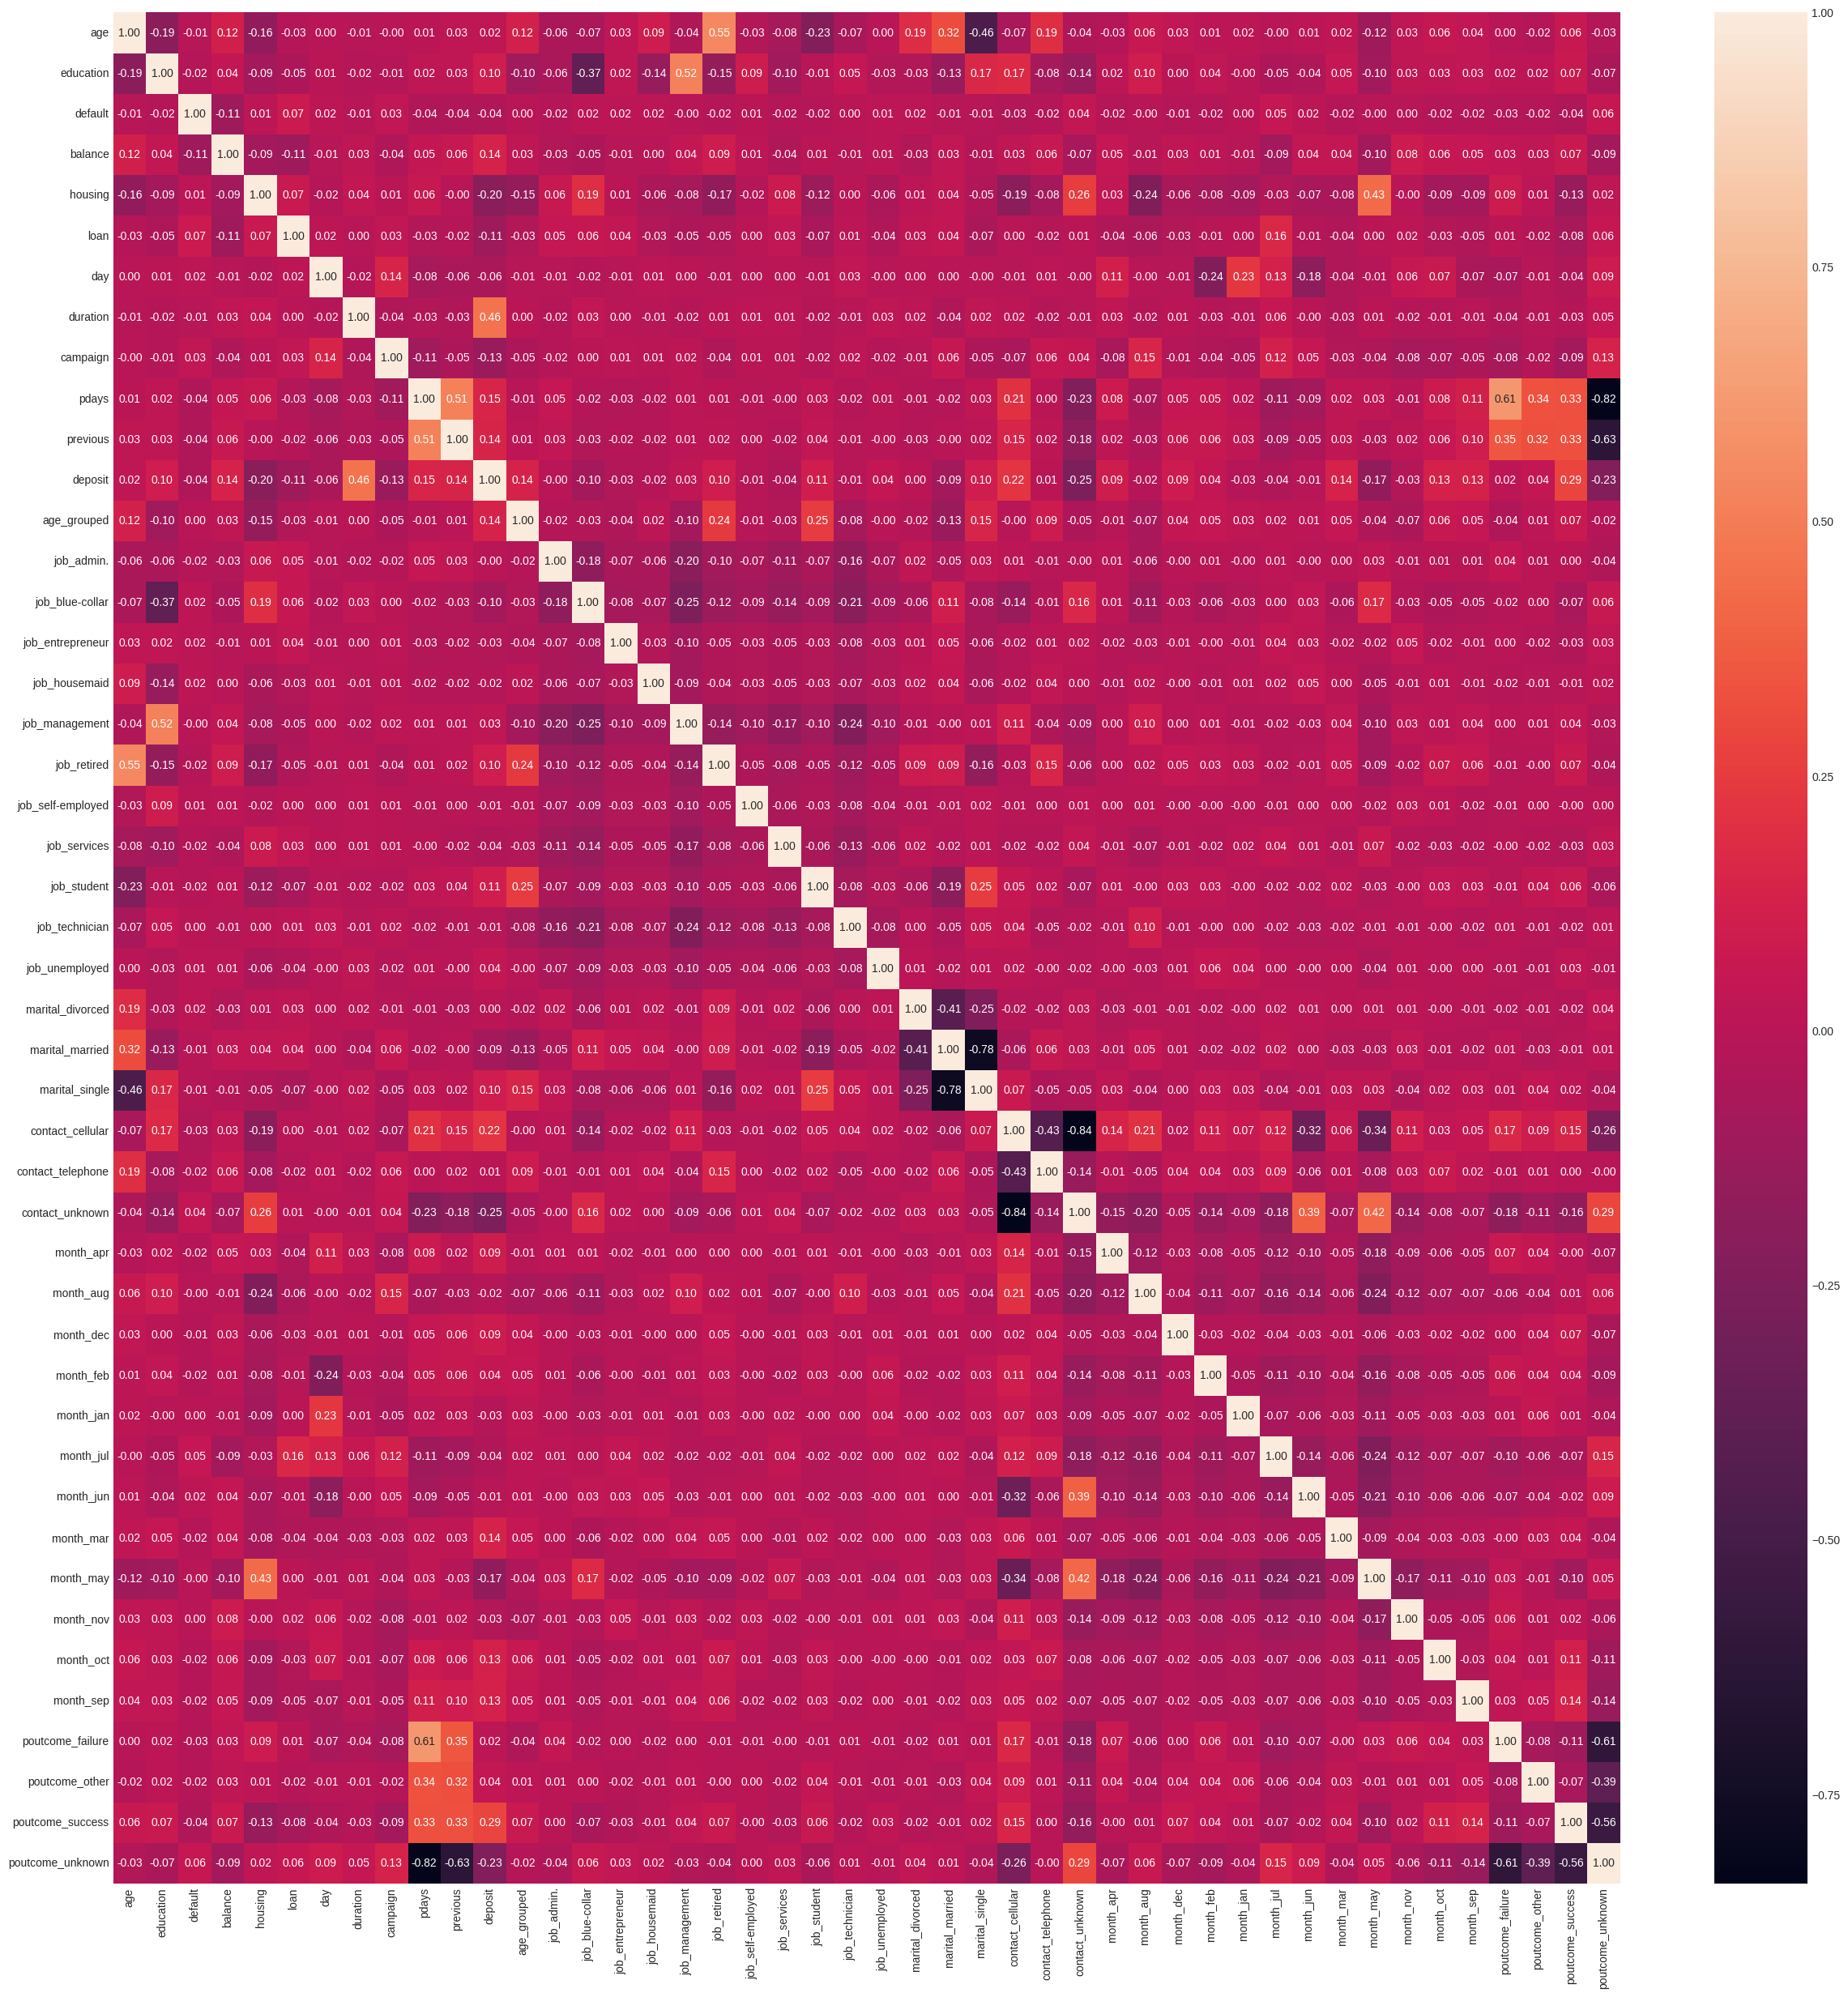

In [299]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, fmt = '.2f', ax=ax)

In [300]:
corr_matrix = df.corr().round(2)
most_corr = corr_matrix['deposit'].sort_values(ascending = False).drop('deposit')[:5]

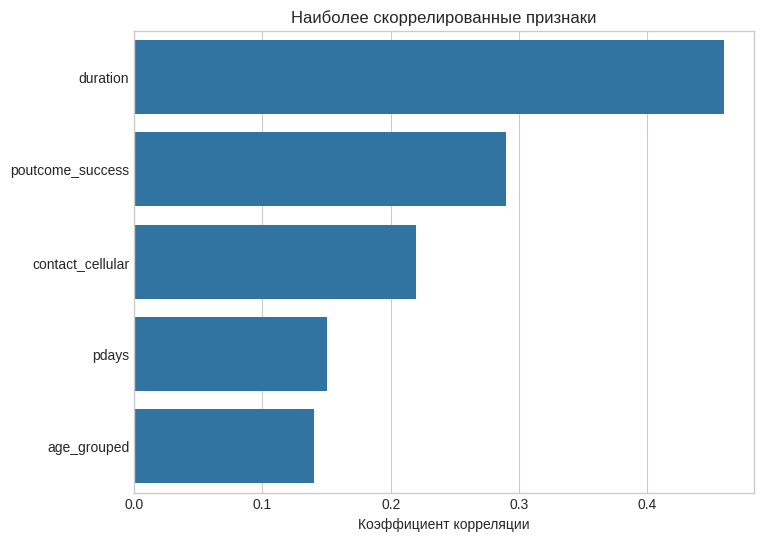

In [301]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(most_corr, orient='h')
plt.title('Наиболее скоррелированные признаки')
ax.set_xlabel('Коэффициент корреляции');

### Задания 7 и 8

In [302]:
# разделяем выборку на обучающи и тестовый наборы
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [303]:
X_test.shape
y.mean().round(2)

0.46

### Задание 9

In [306]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest
kbest = SelectKBest(k=15)
kbest.fit(X_train, y_train)
X_train_new = kbest.transform(X_train)
X_test_new = kbest.transform(X_test)

In [308]:
column_names = kbest.get_feature_names_out()

### Задание 10

In [311]:
# нормализуем данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train_new)
X_test = mm_scaler.transform(X_test_new)
X_train = pd.DataFrame(data = X_train, columns = column_names)
X_test = pd.DataFrame(X_test, columns = column_names)

In [314]:
X_test.iloc[:,0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [315]:
# обучим логистическую регрессию и рассчитаем метрики качества
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

print('accuracy на обучающей выборке: {:.3f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('accuracy на тестовой выборке: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred_test)))

accuracy на обучающей выборке: 0.824
accuracy на тестовой выборке: 0.805


### Задания 2,3,4

In [316]:
# обучим решающие деревья подбирая максимальную глубину
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc.fit(X_train, y_train)
y_dtc_pred_train = dtc.predict(X_train)
y_dtc_pred_test = dtc.predict(X_test)
print('accuracy на обучающей выборке: {:.3f}'.format(metrics.accuracy_score(y_train, y_dtc_pred_train)))
print('accuracy на тестовой выборке: {:.3f}'.format(metrics.accuracy_score(y_test, y_dtc_pred_test)))

accuracy на обучающей выборке: 1.000
accuracy на тестовой выборке: 0.747


Модель явно переобучена, т.к. значение на обучающей выборке равно 1, что значит, что она абсолютно верно классифицировала все объекты. В то же время на тестовой выборке значительно ниже. Модель сильно подстроилась под обучающий набор данных, что приводит к сильному разбросу данных на тестовой выборке.

### Задание 5

In [317]:
# подберем оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'max_depth':[3,5,7],
        'min_samples_split': [2, 5, 7, 10]
        },
    cv=5,
    scoring='accuracy')
gs.fit(X_train, y_train)
y_gs_pred_train = gs.predict(X_train)
y_gs_pred_test = gs.predict(X_test)

print('accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_gs_pred_train)))
print('accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_gs_pred_test)))
print('f1 score на обучающей выборке: {:.3f}'.format(metrics.f1_score(y_train, y_gs_pred_train)))
print('f1 score на тестовой выборке: {:.3f}'.format(metrics.f1_score(y_test, y_gs_pred_test)))

accuracy на обучающей выборке: 0.84
accuracy на тестовой выборке: 0.81
f1 score на обучающей выборке: 0.823
f1 score на тестовой выборке: 0.801


In [318]:
# лучшие параметры
gs.best_params_

{'max_depth': 7, 'min_samples_split': 5}

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [319]:
# обучим на наших данных случайный лес
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators = 100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rfc.fit(X_train, y_train)
y_rfc_pred_train = rfc.predict(X_train)
y_rfc_pred_test = rfc.predict(X_test)
print('метрики на тренировочной выборке: \n', metrics.classification_report(y_train, y_rfc_pred_train))
print('метрики на тестовой выборке: \n', metrics.classification_report(y_test, y_rfc_pred_test))

метрики на тренировочной выборке: 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

метрики на тестовой выборке: 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [320]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gbc.fit(X_train, y_train)
y_gbc_pred_train = gbc.predict(X_train)
y_gbc_pred_test = gbc.predict(X_test)
print('метрики для тренировочной выборки:\n', metrics.classification_report(y_train, y_gbc_pred_train))
print()
print('метрики для тестовой выборки:\n', metrics.classification_report(y_test, y_gbc_pred_test))

метрики для тренировочной выборки:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770


метрики для тестовой выборки:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [321]:
# объединим алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier
sc = StackingClassifier(
    estimators=[['dtc',dtc], ['rfc',rfc], ['gbc',gbc]],
    final_estimator=log_reg,
    n_jobs=-1
)
sc.fit(X_train, y_train)
y_sc_pred_train = sc.predict(X_train)
y_sc_pred_test = sc.predict(X_test)
print('метрики для тренировочной выборки:\n', metrics.classification_report(y_train, y_sc_pred_train))
print()
print('метрики для тестовой выборки:\n', metrics.classification_report(y_test, y_sc_pred_test))

метрики для тренировочной выборки:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      3634
           1       0.85      0.87      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770


метрики для тестовой выборки:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

In [322]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE
selector = RFE(
    estimator=gbc,
    n_features_to_select=3,
    step=1
)

selector = selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

In [338]:
print(X_train.columns)
selector.ranking_

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_grouped', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 1,  4,  1,  8,  3, 11,  5, 12,  2,  6,  9,  7, 10,  1, 13])

In [336]:
# выведем признаки в порядке их важности
pd.Series(selector.ranking_, index=X_train.columns).sort_values()

balance              1
duration             1
poutcome_success     1
contact_unknown      2
pdays                3
housing              4
age_grouped          5
month_mar            6
month_oct            7
campaign             8
month_may            9
month_sep           10
previous            11
contact_cellular    12
poutcome_unknown    13
dtype: int64

### Задания 6,7,8

In [341]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
# установим и импортируем optuna
!pip install optuna
import optuna

In [347]:
# функция для оптимизации гиперпараметров
def objective(trial):
    # задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    # создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    return score

In [348]:
# создаем объект исследования
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# ищем лучшую комбинацию гиперпараметров
study.optimize(objective, n_trials=20)

[I 2024-04-13 16:28:28,177] A new study created in memory with name: RandomForestClassifier
[I 2024-04-13 16:28:29,170] Trial 0 finished with value: 0.877493765586035 and parameters: {'n_estimators': 111, 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.877493765586035.
[I 2024-04-13 16:28:30,304] Trial 1 finished with value: 0.8704402515723271 and parameters: {'n_estimators': 155, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.877493765586035.
[I 2024-04-13 16:28:31,678] Trial 2 finished with value: 0.8682728410513142 and parameters: {'n_estimators': 185, 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.877493765586035.
[I 2024-04-13 16:28:32,880] Trial 3 finished with value: 0.8710485133020344 and parameters: {'n_estimators': 161, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.877493765586035.
[I 2024-04-13 16:28:34,392] Trial 4 finished with value: 0.8767854339978026 and parameters: {'n_estim

In [349]:
study.best_params

{'n_estimators': 142, 'max_depth': 27, 'min_samples_leaf': 2}

In [353]:
print('лучшее значение f1_score на обучающем наборе: {:.2f}'.format(study.best_value))

лучшее значение метрики, полученное при оптимизации гиперпараметров: 0.92


In [360]:
# обучаем модель с оптимальными параметрами
rfc = RandomForestClassifier(**study.best_params, random_state=42)
rfc.fit(X_train, y_train)
y_rfc_pred_train = rfc.predict(X_train)
y_rfc_pred_test = rfc.predict(X_test)
print('f1 score для обучающей выборки: {:.2f}'.format(metrics.f1_score(y_train, y_rfc_pred_train)))
print('f1 score для тестовой выборки: {:.2f}'.format(metrics.f1_score(y_test, y_rfc_pred_test)))

print('accuracy score для обучающей выборки: {:.3f}'.format(metrics.accuracy_score(y_train, y_rfc_pred_train)))
print('accuracy score для тестовой выборки: {:.3f}'.format(metrics.accuracy_score(y_test, y_rfc_pred_test)))

f1 score для обучающей выборки: 0.92
f1 score для тестовой выборки: 0.82
accuracy score для обучающей выборки: 0.929
accuracy score для тестовой выборки: 0.825
